# Première classification

Dans ce notebook, on essaie d'identifier quelques clusters sur les données par les couches cachées du réseau de neurones.

In [1]:
import numpy as np
import sys
from tensorflow import keras
from sklearn.metrics import accuracy_score

# our functions
from tools import buildmodel as mtq
import mnist

# Clustering
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Matplotlib is building the font cache; this may take a moment.


## Prétraitement

On commence d'abord par télecharger les données de [MNIST](https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST).
Cette base regroupe 60000 images d'apprentissage et 10000 images de test, issues d'une base de données antérieure, appelée simplement NIST. Ce sont des images en noir et blanc, normalisées centrées de 28 pixels de côté, contenant des chiffres écrits à la main de `0` à `9`.

On ne garde que les `n` images représentant les chiffres inclus dans `keep`.

In [3]:
keep=[1,7]
n=100

Puis on procèdent à la normalisation de ces données afin d'optimiser le processus d'entraînement.

In [4]:
(x_train , y_train) , (x_test, y_test) = keras.datasets.mnist.load_data(path='all_mnist.npz')

x_train, y_train = mnist.cut_data(x_train, y_train, keep=keep,n=n)
x_test, y_test = mnist.cut_data(x_test,y_test, keep=keep, n=n)

y_train_origin = y_train
y_test_origin = y_test

x_train, y_train = mnist.normalize_dataset(x_train, y_train)
x_test, y_test = mnist.normalize_dataset(x_test, y_test)

print("size of the train dataset : ", len(x_train))
print("size of the test dataset : ", len(x_test))

size of the train dataset :  200
size of the test dataset :  200


## Construction du modèle

Une fois le prétraitement fait, on procède à la construction du modèle.
On donne au modèle un nom `model_name` pour qu'on puisse le réutiliser plus tard si besoin.

[MTQModel](./tools/buildmodel.py) est une classe définie par nous-même afin de faciliter la construction et le paramétrage des modèles.

In [5]:
model_name = "./trained_model_2_16"
model = mtq.MTQModel(model_name)

`MTQModel.build_dense()` est la méthode qui construit un modèle avec des couches Denses.

Liste des paramètres:

- `input_shape`: Nombre de neurones de la couche d'entrée, dans notre cas : 28 * 28 = 784
- `n_neurons`: Le nombre de neurones pour chaque couche. Le dernier élément de la liste correspond à la couche de sortie qui doit correspondre au nombre de Label dans `y_train`
- `load`: Si `True` alors charge le modèle. `model_name` doit être spécifié. sinon construit le modèle.

In [6]:
input_shape = x_train[0].shape
n_neurons=[32, 64, len(y_train[0])]
load=True # Construit le modèle

print('- input_shape: ', input_shape)
print('- n_neurons: ', n_neurons)
print('- load: ', load)

model.build_dense(input_shape=x_train[0].shape, n_neurons=[32,64, len(y_train[0])], load=load, summary=True)

- input_shape:  (784,)
- n_neurons:  [32, 64, 8]
- load:  True


Une fois le modèle construit, on procède à son entaînement. Pour cela on appelle la méthode `fit(x,y)`

In [7]:
if not load:
    model.fit(x_train,y_train,epochs=5)

On procédé à son évaluation grâce à la méthode `evaluate(x,y)`

In [11]:
loss, acc = model.evaluate(x_test, y_test)
print("loss =", loss, ", accuracy =",acc)

loss = 0.07778045535087585 , accuracy = 0.9300000071525574


## Extraction des fonctions d’activations

Pour cela on fait appelle à la méthode `get_hidden_layers_outputs(x)` qui prend en paramètre un `x`qui représente une liste de données (dans notre cas une liste d'images normalisées). Cette méthode retourne une liste d'éléments tels que chaqu'un représente une liste des sorties d'une couche de neurones.

Soit `hd` la sortie retourner par la méthode, alors `hd[i][j][k]` correspond à la sortie donnée par le `k-ième` neurones de la `i-ème` couches étant donné la `j-ème` image de `x`.

In [63]:
hidden_layers = model.get_hidden_layers_outputs(x_test)
print("La taille de `hidden_layers` correspond au nombre de couches cachées:", len(hidden_layers))

une_couche = hidden_layers[0]
print("\nLa taille de `une_couche` correspond au nombre d'élément dans `x_test`:", len(une_couche))

une_couche_un_x = une_couche[0]
print("\nLa taille de `une_couche_un_x` correspond donc bien au nombre de neurones dans cette couches:", len(une_couche_un_x))

La taille de `hidden_layers` correspond au nombre de couches cachées: 2

La taille de `une_couche` correspond au nombre d'élément dans `x_test`: 200

La taille de `une_couche_un_x` correspond donc bien au nombre de neurones dans cette couches: 32


In [64]:
def describe(arr):
    print("+ Measures of Central Tendency") 
    print("Mean =", np.mean(arr)) 
    print("Median =", np.median(arr)) 
    print("+ Measures of Dispersion") 
    print("Minimum =", np.amin(arr)) 
    print("Maximum =", np.amax(arr))
    print("Varience =", np.var(arr)) 
    print("Standard Deviation =", np.std(arr)) 
    print("\n")

for idx,arr in enumerate(hidden_layers):
    print("+ Descriptive analysis for the layer: ", idx+1) 
    describe(arr)

+ Descriptive analysis for the layer:  1
+ Measures of Central Tendency
Mean = 0.21852256
Median = 0.02446067
+ Measures of Dispersion
Minimum = 0.0
Maximum = 1.9040908
Varience = 0.094100714
Standard Deviation = 0.3067584


+ Descriptive analysis for the layer:  2
+ Measures of Central Tendency
Mean = 0.12963307
Median = 0.0
+ Measures of Dispersion
Minimum = 0.0
Maximum = 1.4415239
Varience = 0.043623433
Standard Deviation = 0.20886223




In [71]:
from sklearn.preprocessing import StandardScaler
# Standardization 
scale_hd = []
for i in range(len(hidden_layers)):
    scale_hd.append(StandardScaler().fit_transform(hidden_layers[i]))

for idx,arr in enumerate(scale_hd):
    print("+ Descriptive analysis for the layer: ", idx+1) 
    describe(arr[:,31]) 
    

+ Descriptive analysis for the layer:  1
+ Measures of Central Tendency
Mean = 1.7763568394002505e-17
Median = -0.2837979125653109
+ Measures of Dispersion
Minimum = -0.2837979125653109
Maximum = 5.630967777648555
Varience = 1.0000000000000013
Standard Deviation = 1.0000000000000007


+ Descriptive analysis for the layer:  2
+ Measures of Central Tendency
Mean = 1.7763568394002505e-17
Median = -0.4421182771342522
+ Measures of Dispersion
Minimum = -0.4421182771342522
Maximum = 5.205420165798247
Varience = 0.9999999999999997
Standard Deviation = 0.9999999999999998




In [52]:
# Clustering with KMeans
first_hidden_layers = hidden_layers[0]
cluster = KMeans(2).fit(first_hidden_layers)
y_kmeans = cluster.predict(first_hidden_layers)

In [53]:
np.unique(y_kmeans)

array([0, 1], dtype=int32)

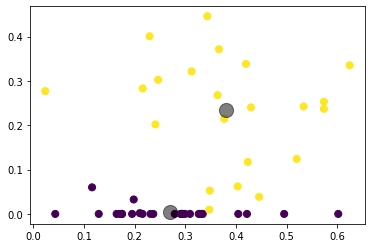

In [54]:
plt.scatter(first_hidden_layers[:, 0], first_hidden_layers[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = cluster.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.show()

In [55]:
# UMAP

import umap.umap_
import umap.plot

umap.plot.output_notebook()
hover_data = pd.DataFrame({'index':np.arange(len(x_test)),
                           'label':y_test_origin,
                           'kmeans': y_kmeans,
                           'prediction': new_r}
                         )
m = 0
for hd in hidden_layers:    
    mapper = umap.umap_.UMAP().fit(hd)
    #umap.plot.points(mapper, labels=y_test_origin)
    p = umap.plot.interactive(mapper, labels=y_kmeans, hover_data=hover_data)
    umap.plot.show(p)



Loading BokehJS ...

In [ ]:
type(m)